In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pyedflib as el
from datetime import datetime, timedelta
from matplotlib import pyplot as pp
import seaborn as sns
pp.rcParams['figure.figsize'] = (16.0, 8.0)

30.07.2016, Pawel [alxd](https://alxd.org/) Chojnacki
# NeuroOn Hypnogram Analysis

Following my principles of Open Access and Open Notebook Science I'd like to present you my comparative analysis of NeuroOn and a professional polisomnograph recording from two nights. To learn more about the experiment itself, please head back to my [previous blog post](https://alxd.org/neuroon-analysis-sources.html).

*[more on NeuroOn and AURA PSG, make assumption that Aura is the closest thing to what is actually happening in the brain]*

At the moment of writing this I haven't been professionally involved in EEG analysis for over two years - please feel free to comment on my code and let me know if any part is unclear or may lead to wrong conclusions.

## Signal formats

NeuroOn signal was obtained by using proprietary Intelclinic's scripts I am not allowed to share. They produced four CSV files, containing respectively:

 - EEG signal (125 Hz)
 - accelerometer signal
 - LED activity
 - Staging ([hypnogram](https://en.wikipedia.org/wiki/Hypnogram))

AURA PSG signal was exported to an EDF format using Grass Technologies PSG TWin 4.5.4 and 4.5.2 to minimize the risk of software-derived artifacts. The channels signals include:

 - EOG1-A1
 - EOG2-A1
 - CHIN1-CHIN2
 - CHIN2-CHIN3
 - F3-A2
 - C3-A2
 - O1-A2
 - F4-A1
 - C4-A1
 - O2-A1
 - SNORE (first night only)
 - FLOW (first night only)
 - CHEST (first night only)
 - ABDOMEN (first night only)
 - ECG (first night only)
 - SaO2 (blood oxygen saturation, first night only)
 - HR (heart rate, first night only)
 - LEG1 (first night only)
 - LEG2 (first night only)
 - Pos (first night only)

PSG signals from both nights were scored by a professional and exported to XLS and CSV files.

Since proper comparative analysis of NeuroOn's and AURA's signals would require an immense amount of work, I'd like to start with comparing their hypnograms.

## Time synchronisation

Hypnogram comparison requires us to synchronise signals from both devices in time. With NeuroOn operating in debug mode there was no way I know of to place markers, leaving us with no easy way to sync. To counter that, for the first several minutes of PSG recording I repeatedly clenched my jaw and moved my eyebrows to introduce muscle artifacts to both signals, allowing me to synchronise both afterwards.

Luckily, the latest version of software I was given by Intelclinic supports recovering timestamps from the device, which could make the whole undertaking a lot easier. It should be enough to:

 - find the initial timestamps of both signals
 - [tests - autocorrelation, correlation in time]
 - visualize them
 - adjust or remove hypnogram datapoints outside of common recording time

At this point it's important to remember that the devices recorded signal with different sampling rate, `125 Hz` for NeuroOn and `200 Hz` for AURA.

In [2]:
# first, open the AURA signal file from the first night
edf_file = el.EdfReader('night_01/psg_signal.edf')

In [3]:
# now open NeuroOn signal file
neuroon_signal = pd.read_csv('night_01/neuroon_signal.csv')
# print(neuroon_signal['timestamp'][0])
neuroon_signal['timestamp'] = neuroon_signal['timestamp'].astype(int)
neuroon_signal['timestamp'] = pd.to_datetime(neuroon_signal['timestamp'], unit='ms')
# account for 2h shift
neuroon_signal['timestamp'] += timedelta(hours=2)
# now in nanoVolts, scale to microVolts
neuroon_signal['signal'] = neuroon_signal['signal'] / 1000.
neuroon_signal[:5]

,timestamp,signal
0,2016-06-20 22:01:00.000,-32.768
1,2016-06-20 22:01:00.008,-32.768
2,2016-06-20 22:01:00.016,-32.768
3,2016-06-20 22:01:00.024,-32.768
4,2016-06-20 22:01:00.032,-32.768


In [4]:
# read respective starting timestamps

psg_start = edf_file.getStartdatetime()
print('PSG recording started', psg_start)

neuroon_start = neuroon_signal['timestamp'][0]
print('NeuroOn recording started', neuroon_start)

PSG recording started 2016-06-20 22:29:48
NeuroOn recording started 2016-06-20 22:01:00


Which suggests that if NeuroOn timestamps are right, it started recording about 28 minutes before the PSG - just after being programmed via the debugger. This is not the only possibility however - we should also check if the signal gathered at the same timestamps corresponds to the signal from the closest PSG electrode - `EOG1-A1`.

In [5]:
# NeuroOn sampling rate was specified to be 125 Hz, but let's check

miliseconds_between_125_samples = neuroon_signal['timestamp'][125] - neuroon_signal['timestamp'][0]
print(miliseconds_between_125_samples, 'miliseconds between 125 NeuroOn samples')

NEUROON_SAMPLE_RATE = 125

seconds_between_startdates = psg_start - neuroon_start
print('We need to adjust the NeuroOn signal', seconds_between_startdates)

no_shifted_signal = neuroon_signal[neuroon_signal['timestamp'] > psg_start]
no_shifted_signal = no_shifted_signal.reset_index(drop=True)

time_difference_us = (no_shifted_signal['timestamp'][0] - psg_start).microseconds

print('Timestamps are within', time_difference_us, 'microseconds from each other')

0 days 00:00:01 miliseconds between 125 NeuroOn samples
We need to adjust the NeuroOn signal 0 days 00:28:48
Timestamps are within 8000 microseconds from each other


Now we can visualize first 10 seconds of each signal to get a visual overview - and run some tests to check if the signals correlate.

In [6]:
# let's get EOG1-A1 signal
# edf_file.getPhysicalDimension(0) # uV - microVolts
# 

PSG_SAMPLE_RATE = edf_file.getSampleFrequency(0)

print(edf_file.getLabel(0))
psg_signal = pd.DataFrame(edf_file.readSignal(0), columns=['signal'])
psg_signal['timestamp'] = [
    psg_start + timedelta(milliseconds=(i * (1000/PSG_SAMPLE_RATE)))
    for i in np.arange(len(psg_signal))
]

psg_signal[:5]

b'EOG1-A1'


,signal,timestamp
0,-12,2016-06-20 22:29:48.000
1,9,2016-06-20 22:29:48.005
2,31,2016-06-20 22:29:48.010
3,41,2016-06-20 22:29:48.015
4,43,2016-06-20 22:29:48.020


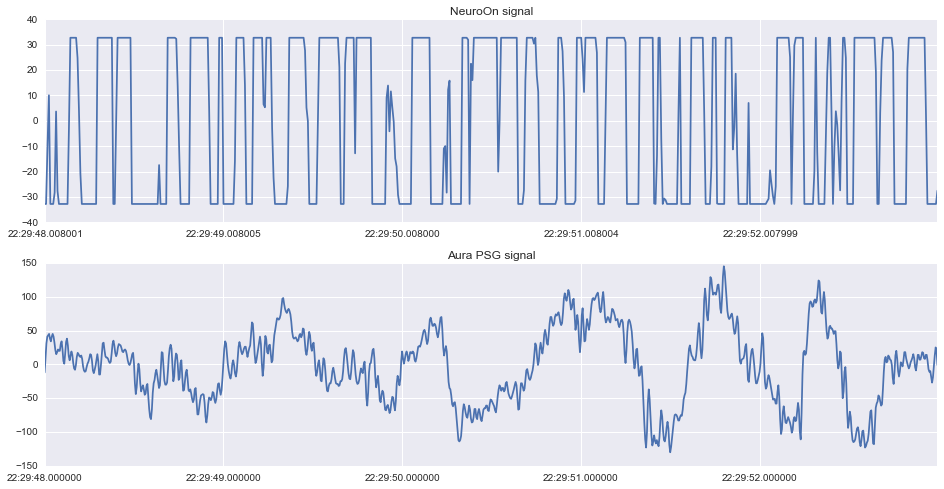

In [60]:
def plot_signal_fragment(
    csv_sig, edf_sig, seconds=10, shift=0,
    csv_title='NeuroOn signal',
    edf_title='Aura PSG signal'
):
#     for signal in [csv_sig, edf_sig]
    pp.subplot(211)
    pp.title(csv_title)
    csv_slice = np.logical_and(
        csv_sig['timestamp'] >= csv_sig['timestamp'][0] + timedelta(seconds=shift),
        csv_sig['timestamp'] < csv_sig['timestamp'][0] + timedelta(seconds=shift + seconds)
    )
    x_csv = csv_sig['timestamp'][csv_slice]
    y_csv = csv_sig['signal'][csv_slice]
    pp.plot(x_csv, y_csv)
    pp.subplot(212)
    pp.title(edf_title)
    edf_slice = np.logical_and(
        edf_sig['timestamp'] >= edf_sig['timestamp'][0] + timedelta(seconds=shift),
        edf_sig['timestamp'] < edf_sig['timestamp'][0] + timedelta(seconds=shift + seconds)
    )
    x_edf = edf_sig['timestamp'][ edf_slice ]
    y_edf = edf_sig['signal'][ edf_slice ]
    pp.plot(x_edf, y_edf)
    return pp.show()

plot_signal_fragment(
    no_shifted_signal, psg_signal, seconds=5
)

It seems that NeuroOn cannot handle all the muscle artifacts from the very first minutes of the experiment. Let's try to shift it 10 minutes and see if the signal makes sense then.

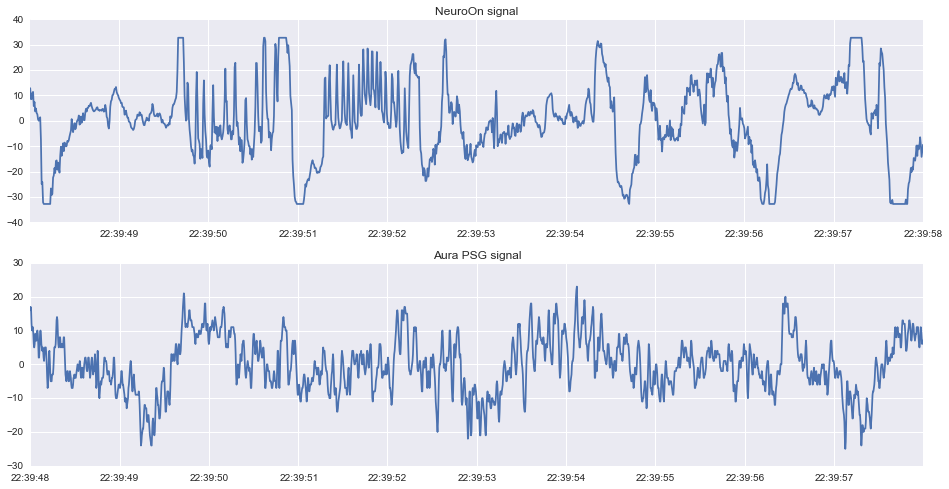

In [61]:
plot_signal_fragment(
    no_shifted_signal, psg_signal,
    shift=600
)

While much clearer, NeuroOn's signal doesn't look similar to Aura's. We shouldn't trust just naked eye (amplitude/time) comparisons, let's try [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) analysis (frequency/time).

In [ ]:
# may be useful to refactor this to share less code with plot_signal_fragment

# TODO: Use pandas

def plot_spectrum_fragment(
    csv_sig, edf_sig, edf_start_time,
    csv_rate=125, edf_rate=200, seconds=10, shift=0,
    cap_frequency=False,
    csv_title='NeuroOn spectrum',
    edf_title='Aura PSG spectrum'
):
    csv_shift = shift * csv_rate
    edf_shift = shift * edf_rate
    # First spectrum
    csv_signal_fragment = csv_sig[
        csv_shift :
        csv_shift + seconds * csv_rate
    ]
    csv_signal_len = len(csv_signal_fragment)
    csv_signal_y = csv_signal_fragment[:,1]
    csv_spectrum_y = np.fft.fft(csv_signal_y) / csv_signal_len
    csv_spectrum_x = np.arange(csv_signal_len) / (csv_signal_len / csv_rate)
    csv_cap_freq = cap_frequency * 10 if cap_frequency else int(csv_signal_len/2)
    x_csv = csv_spectrum_x[:csv_cap_freq] # show one side of freq range
    y_csv = csv_spectrum_y[:csv_cap_freq]
    # First subplot
    pp.subplot(211)
    pp.title(csv_title)
    pp.plot(x_csv, abs(y_csv))
    # Second spectrum
    edf_signal_fragment = edf_sig[edf_shift : edf_shift + seconds * edf_rate]
    edf_signal_len = len(edf_signal_fragment)
    edf_signal_y = edf_signal_fragment
    edf_spectrum_y = np.fft.fft(edf_signal_y) / edf_signal_len
    edf_spectrum_x = np.arange(edf_signal_len) / (edf_signal_len / edf_rate)
    edf_cap_freq = cap_frequency * 10 if cap_frequency else int(edf_signal_len/2)
    x_edf = edf_spectrum_x[:edf_cap_freq]
    y_edf = edf_spectrum_y[:edf_cap_freq]
    # Second subplot
    pp.subplot(212)
    pp.title(edf_title)
    pp.plot(x_edf, abs(y_edf))
    return pp.show()

plot_spectrum_fragment(
    no_shifted_signal, psg_signal, psg_start_timestamp,
    shift=600
)

NeuroOn signal is noisy, let's try too zoom at the first 40Hz of the spectrum.

In [ ]:
plot_spectrum_fragment(
    no_shifted_signal, psg_signal, psg_start_timestamp,
    shift=600, cap_frequency=40
)

**TODO**:
 - use Pandas
 - make more use of Seaborn
 - [windowing](https://en.wikipedia.org/wiki/Window_function)
 - [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
 - correlation in time (maybe the timestamps aren't correct)

In [ ]:
import pandas as pd

neuroon_stages = pd.read_csv('night_01/neuroon_stages.csv')
neuroon_stages.drop('Unnamed: 0', 1, inplace=True)
neuroon_stages['timestamp'] = neuroon_stages['timestamp'].astype(int)
neuroon_stages['timestamp'] = pd.to_datetime(neuroon_stages['timestamp'], unit='ms')